In [1]:
import numpy as np
import emcee

# Problem 1: The Eight Schools

Students at eight schools each participated in a test-prep program. After examination, the average score improvement $ \Delta S$ for each school was recorded, along with the uncertainty on this measurement $ \sigma( \Delta S)$:

   + $ \Delta S$ = [28, 8, -3, 7, -1, 1, 18, 12]

   + $ \sigma( \Delta S$) = [15, 10, 16, 11, 9, 11, 10, 18]


a) Calculate the pooled mean improvement and uncertainty on the mean

b) Fit the data using a hierarchical modeling. Assuming the score improvements $\theta = \Delta S$ were drawn from a population that can be modeled as a Gaussian with mean $\mu$ and uncertainty $\sigma$.

* i. Draw your hyperparameters $\alpha = \{\mu, \sigma\}$ from a Gaussian and Half-Cauchy distribution, respectively
* ii. Test other choices of distributions for the hyper-priors and population. How sensitive are the results?

Sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

In [2]:
mu_s = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sig_s = np.array([15, 10, 16, 11, 9, 11, 10, 18])

mu_pooled = np.average(mu_s, weights=1/(sig_s**2))
sig_pooled = (np.sum(1/(sig_s**2)))**(-0.5) #wtf

print(mu_pooled, sig_pooled)

7.685616724956035 4.071919158402296


In [78]:
# P(D | theta) = 8 gaussians multiplied together (bc independent)
# P(theta | alpha) = one gaussian from which you draw 8 numbers
# P(alpha) = prior on the hyperparameters (1 for each)
#we are not trying to constrain sigma, we're using it as a constraint, and then deriving new sigmas by using the 8 collections of mean samples that we have at the end

from scipy.stats import halfcauchy

def ln_likelihood(theta, delta_s, sigma_s):
    #len(theta) independent Gaussians, where each theta is compared to the known point/stdev, combined
    K = -1 * ((len(theta)/2) * np.log(2*np.pi) - np.sum(np.log(sigma_s)))
    return K - np.sum(((delta_s - theta)**2)/(2*(sigma_s**2)))

def ln_prior(theta, alpha):

    #Hyperparameters
    alpha_mu, alpha_sigma = alpha

    if alpha_sigma < 0:
        return -1e9
    
    #Prior on theta given alpha
    #Version where I compare all thetas individually and then combine (wrong I think)
    # K = -1 * ((len(theta)/2) * np.log(2*np.pi) - np.sum(np.log(len(theta)*alpha_sigma)))
    # P_theta_alpha = K - np.sum(((theta - alpha_mu)**2)/(2*(alpha_sigma**2)))
    #Version where I compare the mean of theta (correct I think)    
    P_theta_alpha = np.log(1/np.sqrt(2*np.pi*alpha_sigma)) - (((np.mean(theta) - alpha_mu)**2)/(2*alpha_sigma**2))

    #Prior on the population mean
    gauss_mu = 0
    gauss_sigma = 20
    prior_alpha_mu = np.log(1/np.sqrt(2*np.pi*gauss_sigma)) - (((alpha_mu - gauss_mu)**2)/(2*gauss_sigma**2))

    #Prior on the population sigma
    cauchy_loc = 0
    cauchy_scale = 2
    prior_alpha_sigma = halfcauchy.logpdf(alpha_sigma, cauchy_loc, cauchy_scale)
    if np.isinf(prior_alpha_sigma):
        prior_alpha_sigma = -1e9

    #Total hyperprior
    P_alpha = prior_alpha_mu * prior_alpha_sigma

    return P_theta_alpha * P_alpha

def ln_posterior(alpha_theta, delta_s, sigma_s):
    alpha = alpha_theta[0:2]
    theta = alpha_theta[2:]
    return ln_likelihood(theta, delta_s, sigma_s) + ln_prior(theta, alpha)

In [79]:
np.random.seed(8)

nwalkers = 100

alpha_mu_0 = np.random.normal(mu_pooled, 1, size=nwalkers)
alpha_sig_0 = np.random.normal(sig_pooled, 1, size=nwalkers)
alpha_0 = np.vstack([alpha_mu_0, alpha_sig_0]).T 

theta_0 = np.random.uniform(-5, 40, size=8*nwalkers).reshape((nwalkers, 8)) #8 numbers

p0 = np.hstack([alpha_0, theta_0])
print(p0)


[[ 7.77682144e+00  4.92578202e+00  3.19281823e+01 -1.51853890e+00
  -3.36353180e+00  2.58280702e+01  1.13347233e+01  3.73166653e+01
   2.67330952e+00  1.35249715e+01]
 [ 8.77689946e+00  4.37929786e+00  1.29355853e+01  1.79758056e+01
   2.06091761e+00  3.92199795e+01  2.34738659e+01  3.68350988e+01
   2.37867470e+01  2.36154159e+01]
 [ 5.73864642e+00  3.99967704e+00  2.20449562e+01  6.07970727e+00
   7.90060676e+00  2.50747370e+00  2.68383914e+01  3.35262198e+01
   4.87506736e+00 -2.20625163e+00]
 [ 6.29926719e+00  3.60307149e+00  1.31556303e+01  3.84569696e+01
   1.50824896e+00  1.99963261e+01  2.99467415e+01  3.77092395e+00
   1.06933228e+01  5.02030460e+00]
 [ 5.38912515e+00  4.00648025e+00  1.60117787e+01  3.70812053e+01
   2.34048632e+01 -2.59469033e-02  1.04247738e+01  2.66688763e+01
   3.97537792e+01  1.12900677e+01]
 [ 1.00954510e+01  5.12453027e+00  1.83529853e+01  5.07236170e+00
   1.06361511e+01  9.81358339e-01  3.29944804e+00  8.45100912e+00
  -2.81383006e+00  7.50094557e+00

In [80]:
sampler = emcee.EnsembleSampler(nwalkers, 10, ln_posterior, args=[mu_s, sig_s])

nsteps = 10000
sampler.run_mcmc(p0, nsteps, skip_initial_state_check=True)

State([[ 9.62309486e+00  2.71932940e-01  2.48407885e+01  8.54306701e+00
   9.92024111e+00  1.28049186e+01  4.11534786e-01 -5.82274765e+00
   1.30888105e+01  1.40944572e+01]
 [ 4.68296024e+00  5.51801227e-03  1.38818338e+01  6.30449050e+00
  -3.56900210e+00  1.77371051e+00 -8.78721041e+00  2.06977834e+00
   1.67520344e+01  9.03621482e+00]
 [ 7.06566938e+00  2.19565584e-01  3.14901501e+01  9.51172350e+00
  -5.30521849e+00  1.64464124e+01 -9.00731808e+00 -1.11681500e+01
   1.10997885e+01  1.18815016e+01]
 [ 3.17000912e+00  7.07011861e-02  1.89846927e+01 -1.57278621e+01
  -1.21886494e+01  1.39467598e-01  2.35508374e+00 -8.14274013e+00
   1.77667768e+01  2.24901843e+01]
 [ 8.90808148e+00  4.16243471e-01  2.77985026e+01  6.11046761e+00
  -2.48397785e-01 -4.36534820e+00  9.16187833e+00 -5.69382625e+00
   2.91121079e+01  8.44138832e+00]
 [ 2.91102918e+00  4.08136320e-03  1.77684205e+01 -3.48252137e-01
  -5.63907236e+00  2.94443359e+00 -7.05977510e+00 -1.14815401e+01
   1.76165123e+01  9.514455

In [81]:
chain = sampler.get_chain()
print(chain.shape)

(10000, 100, 10)


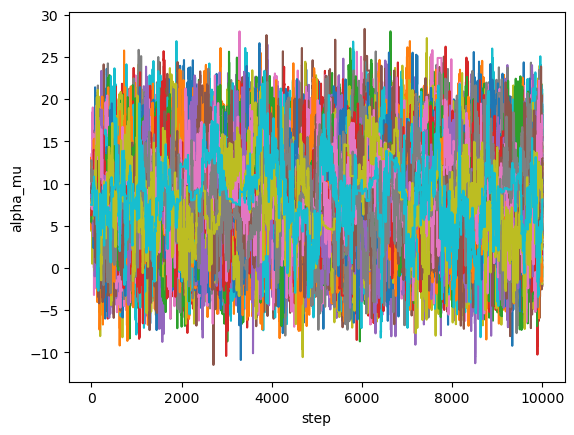

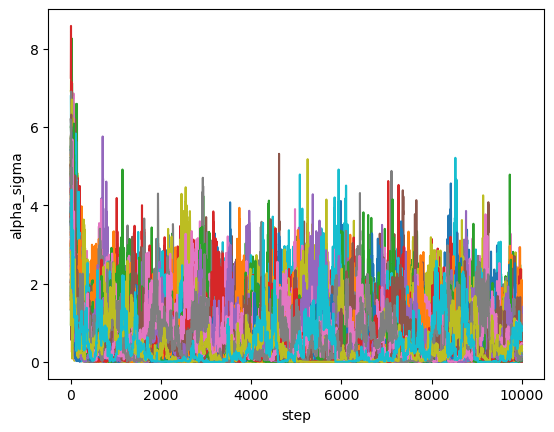

In [83]:
%matplotlib inline

for n in range(nwalkers):
    plt.plot(chain[:,n,0])
plt.xlabel('step')
plt.ylabel('alpha_mu')
plt.show()

for n in range(nwalkers):
    plt.plot(chain[:,n,1])
plt.xlabel('step')
plt.ylabel('alpha_sigma')
plt.show()

# Problem 2: The Five Districts

The test-prep program was expanded across five districts, for a total of 27 schools. For each school, the mean score improvement, uncertainty on the mean, and number of hours each student spent studying was recorded.

### Exercises

a) Load the Five Districts dataset (five_districts.csv) and plot the data
b) Determine the expected score improvement per hour studied for each school using three different models:

+ i. A fully pooled model
+ ii. Independent estimates for each district
+ iii. A hierarchical model that asserts a relationship between the schools and districts.

For all three cases, sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

For the third option, draw the relationship as a directed acyclic graph. Justify your choices of distributions for parameters and hyper-parameters, and test your results for sensitivity to modeling choices.


# Problem 3: Dyson Spheres

Congratulations! You've detected a strange class of objects that you suspect are [Dyson spheres](https://en.wikipedia.org/wiki/Dyson_sphere). Your data are sparse, but you nonetheless detect hints of variability in each object's brightness.

a) Load the Dyson Sphere dataset (dyson_spheres.csv) and plot the time series data. What do you notice about the relative amplitude variations?

b) For each object, compute a Lomb-Scargle periodogram. What do you notice about the frequency-power plot?

c) Assume that each object's time series can be modeled as a single-component sinusoid. Construct a hierarchical model for the population, asserting some population-level relationship between the amplitudes, frequencies, and phases for each object's sinusoid. Which parameters might be expected to be correlated or independent of one another?

# Problem 4: Astrophysics

Select an astrophysical dataset of your choosing. Describe any hierarchical structure in the data using a directed acyclic graph. Build a simple hierarchical model for the data. You may wish to use only a few member objects of your dataset in order to more rapidly iterate while developing.